In [ ]:
#  ------------------------------  LISCENCE PLATE ANNOTATION DETECTION  ------------------------------

In [30]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO('runs/detect/train4/weights/best.pt')

def detect_license_plate(image_path):
    # Predict
    results = model(image_path)[0]
    
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    
    # Draw bounding boxes
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls_id = int(box.cls[0])

        # Draw green box and label
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_rgb, f'{model.names[cls_id]} {conf:.2f}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()



image 1/1 C:\Users\anilk\Downloads\numb_plate_rec\test\922.jpg: 416x416 1 license_plate, 77.0ms
Speed: 2.0ms preprocess, 77.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)


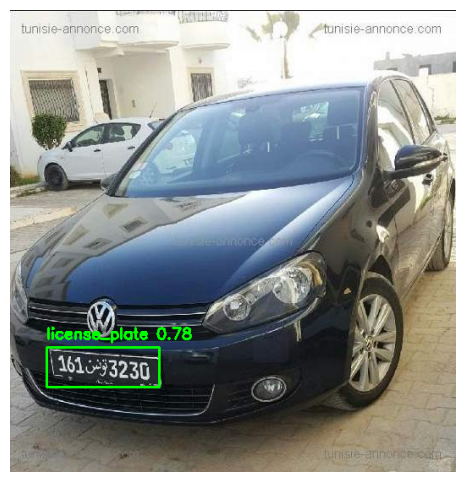

In [31]:
detect_license_plate(r'C:\Users\anilk\Downloads\numb_plate_rec\test\922.jpg')

In [ ]:
#  ------------------------------  TEXT DETECTION FROM LISCENCE PLATE IMAGE  ------------------------------

In [32]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("license_plate_model.h5")

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 128
characters = ['0','1','2','3','4','5','6','7','8','9','N','T','blank']
char_to_idx = {c: i for i, c in enumerate(characters)}
idx_to_char = {i: c for c, i in char_to_idx.items()}


def preprocess_image(img_path):
   
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return np.expand_dims(img, axis=0)  # Add batch dimension

def decode_prediction(preds):
    decoded = ''
    for p in preds:
        idx = np.argmax(p[0])  # p[0] because shape is (1, num_classes)
        char = idx_to_char[idx]
        if char != 'blank':
            decoded += char
    return decoded


import matplotlib.pyplot as plt
import cv2

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Shape: (64, 128, 1)
    return np.expand_dims(img, axis=0)  # Shape: (1, 64, 128, 1)

def decode_prediction(preds):
    decoded = ''
    for p in preds:
        idx = np.argmax(p[0])  # p is shape (1, NUM_CLASSES)
        char = idx_to_char[idx]
        if char != 'blank':
            decoded += char
    return decoded




1/1 [==============================] - 0s 363ms/step
133T6719


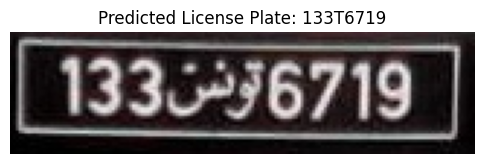

In [33]:
# Path to image
img_path = r"C:\Users\anilk\Downloads\numb_plate_rec\license_plates_recognition_train\100.jpg"

# Preprocess and predict
input_image = preprocess_image(img_path)
preds = model.predict(input_image)
predicted_text = decode_prediction(preds)
print(predicted_text)

# Show the image with prediction
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for plt

plt.figure(figsize=(6, 3))
plt.imshow(img_rgb)
plt.title(f"Predicted License Plate: {predicted_text}")
plt.axis('off')
plt.show()

In [ ]:
#  ------------------------------ PIPELINE OF TRAINED MODELS - text recognition in car image(liscence plate included) ------------------------------

#  ------------------------------ LISCENCE PLATE ANNOTATION DETECTION + TEXT DETECTION FROM LISCENCE PLATE IMAGE  ------------------------------

In [5]:
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Load models
yolo_model = YOLO('runs/detect/train4/weights/best.pt')
ocr_model = load_model("license_plate_model.h5")

# OCR configuration
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 128
characters = ['0','1','2','3','4','5','6','7','8','9','N','T','blank']
char_to_idx = {c: i for i, c in enumerate(characters)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

def preprocess_for_ocr(image):
    """Preprocess cropped license plate image for OCR"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (IMAGE_WIDTH, IMAGE_HEIGHT))
    gray = gray.astype(np.float32) / 255.0
    gray = np.expand_dims(gray, axis=-1)  # Add channel dimension
    return np.expand_dims(gray, axis=0)   # Add batch dimension

def decode_prediction(preds):
    """Decode OCR model predictions to text"""
    decoded = ''
    for p in preds:
        idx = np.argmax(p[0])  # p[0] because shape is (1, num_classes)
        char = idx_to_char[idx]
        if char != 'blank':
            decoded += char
    return decoded

def visualize_results(original_img, annotated_img, plate_crop, plate_text):
    """Create 4-row visualization as specified"""
    plt.figure(figsize=(12, 10))
    
    # Row 1: Original Image
    plt.subplot(4, 1, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("1. Original Image")
    plt.axis('off')
    
    # Row 2: Detection Results
    plt.subplot(4, 1, 2)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("2. License Plate Detection (Green Box)")
    plt.axis('off')
    
    # Row 3: Zoomed Plate + Text Prediction
    plt.subplot(4, 1, 3)
    plt.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"3. Zoomed Plate | Predicted: {plate_text}")
    plt.axis('off')
    
    # Row 4: Final Combined Result
    plt.subplot(4, 1, 4)
    final_img = annotated_img.copy()
    cv2.putText(final_img, plate_text, (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
    plt.title("4. Final Result: Detection + Recognition")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def process_image(image_path):
    """Process image through the full pipeline"""
    # Load image
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"Error loading image: {image_path}")
        return
    
    print(f"\nProcessing: {os.path.basename(image_path)}")
    
    # YOLO Detection
    results = yolo_model(original_img)[0]
    if len(results.boxes) == 0:
        print("No license plates detected")
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title("No plates detected")
        plt.axis('off')
        plt.show()
        return
    
    # Process first detected plate (for simplicity)
    box = results.boxes[0]
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    conf = float(box.conf[0])
    
    # Create annotated image
    annotated_img = original_img.copy()
    cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    
    # Crop and recognize plate
    plate_crop = original_img[y1:y2, x1:x2]
    ocr_input = preprocess_for_ocr(plate_crop)  # Removed the unpacking
    preds = ocr_model.predict(ocr_input)
    plate_text = decode_prediction(preds)
    
    print(f"Detected Plate: {plate_text} (Confidence: {conf:.2f})")
    
    # Generate the 4-row visualization
    visualize_results(original_img, annotated_img, plate_crop, plate_text)




Processing: 1083.jpg

0: 416x320 1 license_plate, 63.8ms
Speed: 3.0ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 320)
1/1 [==============================] - 0s 493ms/step
Detected Plate: 148T2903 (Confidence: 0.80)


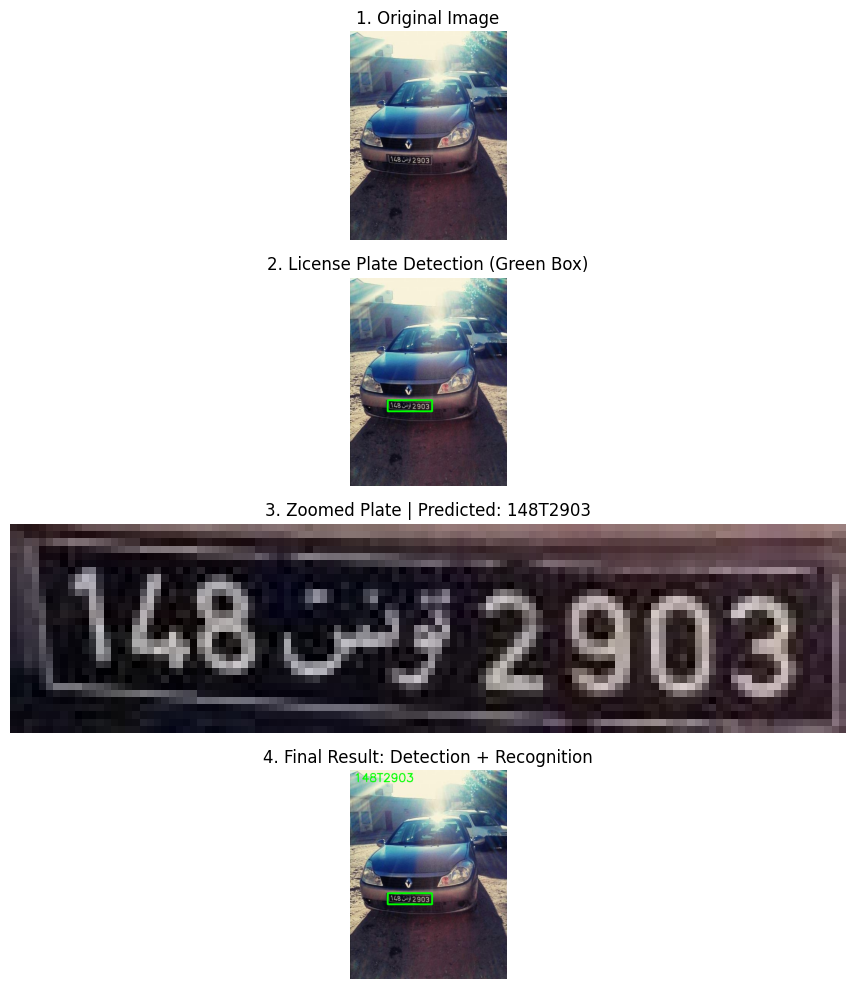

In [6]:
img_path = r"C:\Users\anilk\Downloads\numb_plate_rec\test\1083.jpg"
process_image(img_path)